# Example - Non-linear classification with a neural network

This example shows how to use the machine learning framework to train a neural network to classify non-linear data. The dataset is synthetic and consists of two classes of points in a 2D space samples from two ellipses.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Import model components
from framework.layers import Sequential, Linear
from framework.activations import ReLU
from framework.loss import SoftmaxCrossEntropy
from framework.network import train_one_step

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## Create the neural network

In [18]:
model = Sequential([
    Linear(2, 20), ReLU(),    # Input layer (2D spiral data) with a larger hidden layer
    Linear(20, 10), ReLU(),   # Second hidden layer
    Linear(10, 5), ReLU(),    # Third hidden layer
    Linear(5, 2),             # Output layer for classification
])

loss = SoftmaxCrossEntropy()

# Hyperparameters

# Learning rate: size of the step to take in the parameter space
learning_rate = 0.02
# Weight decay: regularization parameter to avoid overfitting
weight_decay = 0.0005

mod_0: <framework.layers.linear.Linear object at 0x11ececc80>
mod_1: <framework.activations.relu.ReLU object at 0x11eb7d010>
mod_2: <framework.layers.linear.Linear object at 0x11ecedc10>
mod_3: <framework.activations.relu.ReLU object at 0x11edeea50>
mod_4: <framework.layers.linear.Linear object at 0x11edefe00>
mod_5: <framework.activations.relu.ReLU object at 0x11f8fc800>
mod_6: <framework.layers.linear.Linear object at 0x11f8fda90>


## Generate synthetic data

In [19]:
def twospirals(n_points=120, noise=1.4, twist=600):
    """
      Returns a two spirals dataset.
    """
    np.random.seed(0)
    n = np.sqrt(np.random.rand(n_points, 1)) * twist * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    X, T = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points).astype(int), np.ones(n_points).astype(int))))
    return X, T

X, T = twospirals(n_points=200, noise=1.4, twist=600)

## Utility functions to plot the data and the decision boundary

In [20]:
def plot_data(X, T):
    ax.scatter(X[:, 0], X[:, 1], s=40, c=T, cmap=plt.cm.Spectral)


def plot_boundary(model, X, targets, threshold=0.0):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    y = model.forward(X_grid)[:, 0]

    ax.contourf(xx, yy, y.reshape(*xx.shape) < threshold, alpha=0.5)
    plot_data(X, targets)
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    plt.show()

### Train Model + Real-time decision boundary plot

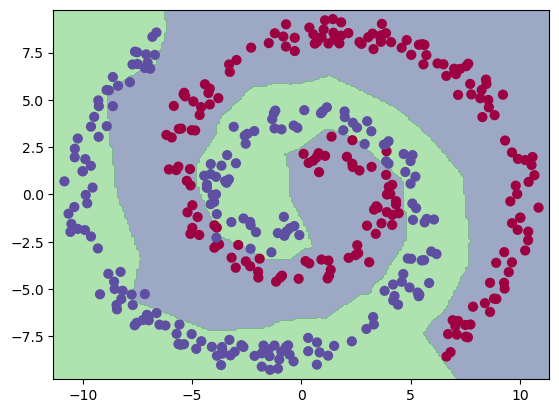

step:  19800  cost:  0.025386388515388828


In [21]:
# Perform 200,000 steps of training
for i in range(20000):
    curr_loss = train_one_step(model, loss, learning_rate, X, T, weight_decay=0.0005)
    if i % 200 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots()

        plot_boundary(model, X, T, 0.5)
        print("step: ", i, " cost: ", curr_loss)